# Asset Pricing 2: Homework 1
### Trent Potter  
### Winter 2025

---

### Outline
#### Data
* `StockPortfolios.csv`: monthly stock returns of 30 portfolios from 1963-10 to 2013-12 
* `FFMktFct.csv`: monthly broad market returns and tbills returns of 30 portfolios from 1963-10 to 2016-07 
#### Problem 1: Estimating an SDF with the Market Factor  
**Estimation Procedures**

Calculate SDF parameters ($b$ and $µ_F$), standard errors, $\chi^2$-statistics, and HJ-distance under three difference cases:  
   - **Assumption IID**: Equivalent to timeseries regression.   
   - **First-stage GMM**: Using $W=I$ weight matrix.  
   - **Two-step GMM**: Using optimal $W=S^{-1}$ weight matrix.  
Discussion follows.

#### Problem 2: Principal Component Factors in the SDF  
**Estimation Procedures**

Compute the first five principal components of the 30 portfolio excess returns, then re-run the above analysis.
   - **Assumption IID**: Equivalent to timeseries regression.   
   - **First-stage GMM**: Using $W=I$ weight matrix.  
   - **Two-step GMM**: Attempt optimal $W=S^{-1}$ weight matrix. 
     - Investigating invertibility of $S$ matrix  
     - Using pseudo-inverse of $S$
     - Without $K$ pricing factor moment conditions
       
**Analysis and Discussion**
   - Proof / Disproof on equivalence time-series regression and GMM on PCs as factors.
   - Explaining results from alternative approaches (pseudo-inverse and reduced moment conditions)  
   - Discussion of pseudo-inverse's impact on weighting  

In [604]:
import pandas as pd
import numpy as np
from numpy.linalg import inv as inv
from IPython.display import display, HTML
import matplotlib.pyplot as plt

display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [605]:
# Read in the CSV files
stock_portfolios = pd.read_csv('StockPortfolios.csv', index_col=0, parse_dates=True, date_format='%Y%m')
ff_mkt_fct = pd.read_csv('FFMktFct.csv', index_col=0, parse_dates=True, date_format='%Y%m')

# Truncate ff_mkt_fct to the same time period as stock_portfolios
ff_mkt_fct = ff_mkt_fct.loc[:'2013-12']

# Concatenate the two dataframes along the column axis
Z = pd.concat([stock_portfolios/100, ff_mkt_fct], axis=1)

# Subtract the "Tbill" column from every other column
for column in Z.columns:
  if column != 'Tbill':
    Z[column] = Z[column] - Z['Tbill']
Z.drop('Tbill', axis=1, inplace=True)

display(Z)

,Size_Short,Size_Long,GrossProfitability_Short,GrossProfitability_Long,Value_Short,Value_Long,ValProf_Short,ValProf_Long,Accruals_Short,Accruals_Long,...,ValMom_Long,IdiosyncraticVolatility_Short,IdiosyncraticVolatility_Long,Momentum_Short,Momentum_Long,LongRunReversals_Short,LongRunReversals_Long,BetaArbitrage_Short,BetaArbitrage_Long,Rmarket
1963-10-01,0.0325,0.0025,-0.0046,0.0099,0.0366,0.0024,-0.0127,0.0129,0.0001,0.1088,...,0.0092,0.0113,0.0376,0.0174,0.0497,0.0316,-0.0007,0.0199,-0.0066,0.0253
1963-11-01,-0.0082,-0.0238,-0.0059,-0.0175,-0.0015,0.0063,-0.0113,-0.0025,-0.0142,-0.0463,...,0.0151,-0.0265,0.0101,-0.0021,-0.0032,0.0107,0.0010,-0.0154,-0.0146,-0.0085
1963-12-01,0.0230,-0.0259,0.0198,0.0030,0.0246,0.0343,0.0219,-0.0161,0.0089,0.0148,...,0.0384,-0.0063,0.0202,-0.0272,0.0040,0.0117,-0.0087,0.0020,0.0139,0.0183
1964-01-01,0.0282,0.0409,0.0157,0.0085,0.0261,0.0259,0.0138,0.0248,0.0362,0.0324,...,0.0362,-0.0179,0.0342,0.0146,0.0140,0.0181,0.0426,0.0170,0.0109,0.0224
1964-02-01,0.0121,0.0246,0.0093,0.0154,0.0193,0.0587,0.0089,0.0428,0.0144,0.0221,...,0.0458,0.0140,0.0092,0.0176,0.0321,0.0159,0.0258,0.0138,0.0113,0.0154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-01,-0.0282,-0.0284,-0.0292,-0.0279,-0.0204,-0.0367,-0.0178,-0.0277,-0.0173,-0.0047,...,-0.0469,0.0067,-0.0443,0.0301,-0.0270,-0.0095,-0.0415,-0.0211,-0.0420,-0.0271
2013-09-01,0.0296,0.0640,0.0274,0.0584,0.0626,0.0239,0.0673,0.0793,0.0649,0.0716,...,0.0254,0.0832,0.0200,0.0052,0.0740,0.0437,0.0266,0.0784,0.0160,0.0377
2013-10-01,0.0475,0.0194,0.0152,0.0398,0.0380,0.0323,0.0272,0.0567,0.0154,0.0414,...,0.0349,-0.0109,0.0466,0.0512,0.0236,0.0462,0.0300,0.0173,0.0465,0.0418
2013-11-01,0.0338,0.0544,-0.0069,0.0218,0.0261,0.0534,0.0269,0.0198,0.0311,0.0234,...,0.0505,0.0282,0.0347,0.0321,0.0335,0.0413,0.0730,0.0441,0.0303,0.0312


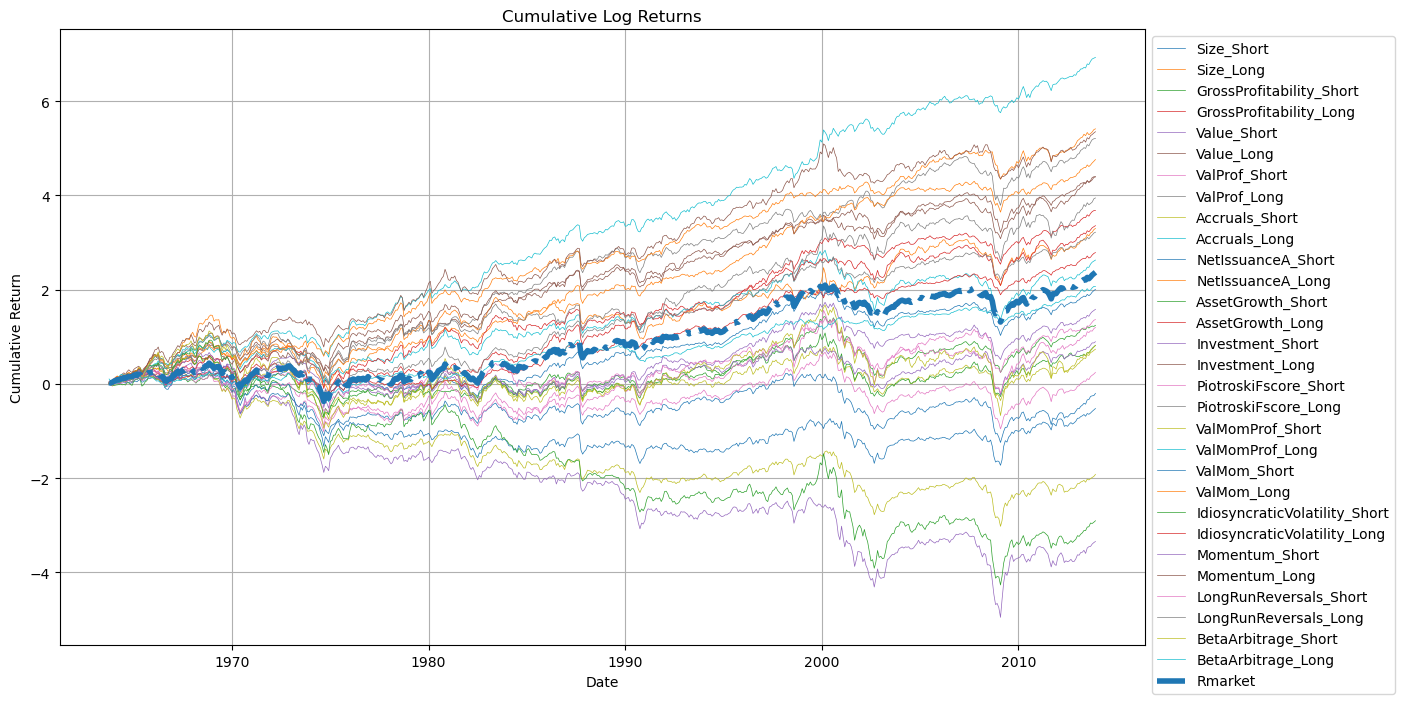

In [606]:
# Calculate cumulative returns
cumulative_log_returns = np.log((1+ Z).cumprod())

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for column in cumulative_log_returns.columns:
  if column == 'Rmarket':
    plt.plot(cumulative_log_returns.index, cumulative_log_returns[column], label=column, linewidth=4, linestyle='-.')
  else:
    plt.plot(cumulative_log_returns.index, cumulative_log_returns[column], label=column, linewidth=.5)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Cumulative Log Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Problem 1 - SDF Estimation w/ Market Factor

In [607]:
# Market Factor
F = Z['Rmarket']
F= F.to_numpy().reshape(-1,1)
Z = Z.iloc[:,:-1].reset_index(drop=True)

T = Z.shape[0]
N = Z.shape[1]
K = F.shape[1]

In [608]:
from scipy.stats import chi2

# Approach 1, with matrix OLS interpretation
beta = inv(F.T@F)@F.T@Z
alpha = (Z.reset_index(drop=True) - (beta.T@F.T).T).mean()
factor_cov = F.T@F/T
mu_hat = F.mean().reshape(1,1)
b_hat = inv(factor_cov)@mu_hat

# Errors
epsilon = Z - (beta.T@F.T).T
epsilon_cov = epsilon.T@epsilon
square_sharpe = alpha.T@inv(epsilon_cov)@alpha


# JT test, Chi-squared with N-K -> 30 (Z) + 2 (factor px'ing & mean) - 2 (b & mu) = 30 DOF
T = Z.shape[0]
J = T*alpha.T@inv(epsilon_cov)@alpha*inv(1+mu_hat.T@inv(factor_cov)@mu_hat).item()
p_value = 1-chi2.cdf(J, df=30)

method_1_results = pd.concat([
    pd.Series(beta.T[0], index=Z.columns, name='beta'), 
    pd.Series(alpha, index=Z.columns, name='alpha'),
], axis=1)
print(f"mu_hat: {mu_hat[0][0]:0.5g}\t b_hat: {b_hat[0][0]:0.5g}\nJ: {J:0.5g} \tAccept with p={p_value:0.5f} \nsquare_sharpe: {square_sharpe:0.5g} \n ")
display(method_1_results)

mu_hat: 0.0049582	 b_hat: 2.4305
J: 0.2285 	Accept with p=1.00000 
square_sharpe: 0.00038351 
 


,beta,alpha
Size_Short,0.9278,-0.0003
Size_Long,1.1192,0.0020
GrossProfitability_Short,0.9438,-0.0015
GrossProfitability_Long,0.9393,0.0026
Value_Short,1.0685,-0.0013
Value_Long,0.9947,0.0038
ValProf_Short,1.1835,-0.0038
ValProf_Long,1.0741,0.0050
Accruals_Short,1.2580,-0.0031
Accruals_Long,1.1265,0.0004


In [609]:
moments((mu_hat,b_hat), X)

array([[ 0.02034179,  0.03085802,  0.00233917, ...,  0.01891025,
        -0.00629464,  0.02404917],
       [-0.01345821, -0.00849127, -0.02458926, ..., -0.01588778,
        -0.01508202, -0.00877803],
       [ 0.01334179,  0.02222993, -0.02503452, ...,  0.00191368,
         0.01347027,  0.01770659],
       ...,
       [ 0.03684179,  0.04329138,  0.01769682, ...,  0.01574253,
         0.04232717,  0.03805713],
       [ 0.02624179,  0.03162669,  0.05095608, ...,  0.04132553,
         0.02837537,  0.02921008],
       [ 0.02314179,  0.02371481,  0.02400285, ...,  0.03538878,
        -0.0001588 ,  0.02651951]])

In [610]:

def g_conds(Z, F, mu_hat, b_hat):
    m = (1 - (F - mu_hat)@b_hat).T
    return np.hstack([F-mu_hat, m.T*Z, m.T*F])



# JT test, Chi-squared with N-K -> 30 (Z) + 2 (factor px'ing & mean) - 2 (b & mu) = 30 DOF
T = Z.shape[0]
JT_test = T*square_sharpe*(1+mu_hat.T@inv(factor_cov)@mu_hat).item()

g_t = g_conds(Z, F, mu_hat, b_hat)
g_hat= g_t.mean(axis=0).reshape(-1,1)
S = np.mean([np.outer(g_i,g_i) for g_i in g_t], axis=0)
J = T*(g_hat.T@inv(S)@g_hat).item()
p_value = 1-chi2.cdf(J, df=30)

In [637]:
import numpy as np
from scipy.optimize import minimize

N = Z.shape[1]
K = F.shape[1]

# Define the moment conditions
def moments(theta, X):
    """Moment conditions g(theta, X)"""
    
    b, mu = theta
    F, Z = X
    m = (1 - (F - mu.reshape(-1,1))@b.reshape(-1,1)).T
    
    return np.hstack([F-mu, m.T*Z, m.T*F])

# Define the gradient matrix G(theta)
def gradient_matrix(theta, X, alt_approach=False):
    """Gradient matrix G(theta) = dE[g(theta, X)]/dtheta"""
    b, mu = theta
    mu = mu.reshape(-1,1)
    b = b.reshape(-1,1)
    F, Z = X
    F_bar = np.mean(F, axis=0,keepdims=True)
    Z_bar = np.mean(Z, axis=0,keepdims=True)
     
    beta = (inv(F.T@F)@F.T@Z).T # NxK
    f_cov = np.cov(F.T, ddof=0).reshape(-1,1) # KxK
    
    G = np.zeros((N+2*K, 2*K))
    
    if alt_approach: #self derived (unsure if correct)
        #Left K columns
        G[0:N,       0:K]   = -Z.T@(F-mu)/T     # Derivative of test pricing cond w.r.t b
        G[N:N+K,     0:K]   = -F.T@(F-mu)/T     # Derivative of factor pricing cond w.r.t b
        G[N+K:N+2*K, 0:K]   = np.zeros((K, K))  # Derivative of mean factor pricing cond w.r.t b
        
        #Right K columns
        G[0:N,       K:2*K] = Z_bar.T@b         # Derivative of test pricing cond w.r.t mu
        G[N:N+K,     K:2*K] = F_bar.T@b         # Derivative of factor pricing cond w.r.t mu
        G[N+K:N+2*K, K:2*K] = -np.eye(K)        # Derivative of mean factor pricing cond w.r.t mu
    
    else: #from the notes
        #Left K columns
        G[0:N,       0:K]   = -beta@f_cov        # Derivative of test pricing cond w.r.t b
        G[N:N+K,     0:K]   = -f_cov         # Derivative of factor pricing cond w.r.t b
        G[N+K:N+2*K, 0:K]   = np.zeros((K, K))  # Derivative of mean factor pricing cond w.r.t b
        
        #Right K columns
        G[0:N,       K:2*K] = beta @ mu @ b.T # Derivative of test pricing cond w.r.t mu
        G[N:N+K,     K:2*K] = mu @ b.T          # Derivative of factor pricing cond w.r.t mu
        G[N+K:N+2*K, K:2*K] = -np.eye(K)        # Derivative of mean factor pricing cond w.r.t mu
    return G #N+2K x 2K

# GMM objective function
def gmm_objective(theta, X, W):
    """Compute the GMM objective Q(theta)"""
    # Compute the sample moments
    g = moments(theta, X).mean(axis=0)  # Average of moment conditions
    obj = g.T @ W @ g
    grad = gradient_matrix(theta, X).T @ W @ g
    return obj #, grad  ## Don't return, analytical gradient is not working

# Initial weighting matrix (identity)
W = np.eye(N+2*K)
X = (F, Z.to_numpy())
# Optimize the GMM objective
result = minimize(
    fun=gmm_objective,
    x0=np.array([b_hat.item(), mu_hat.item()]),  # Initial guess for theta
    # x0=np.array([.002, 2.01]),  # mu,
    args=(X, W),  # Data, weighting matrix, gradient function
    method='BFGS',
    jac=False,
    tol=1e-7,
    options={'disp': True,
             'maxiter': 1000}
    
)
result

Optimization terminated successfully.
         Current function value: 0.000536
         Iterations: 6
         Function evaluations: 36
         Gradient evaluations: 12


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0005356246374853948
        x: [ 2.120e+00  3.825e-03]
      nit: 6
      jac: [ 2.183e-11 -4.045e-09]
 hess_inv: [[ 3.052e+03  6.354e-01]
            [ 6.354e-01  4.967e-01]]
     nfev: 36
     njev: 12

array([[ 0.0103335 ],
       [ 0.01841064],
       [ 0.00781438],
       [ 0.01758604],
       [ 0.00967129],
       [ 0.02127247],
       [ 0.0049793 ],
       [ 0.02500292],
       [ 0.00768261],
       [ 0.01444858],
       [ 0.0028774 ],
       [ 0.02184885],
       [ 0.00807318],
       [ 0.0173186 ],
       [ 0.00794725],
       [ 0.02138881],
       [ 0.01068004],
       [ 0.0156138 ],
       [-0.00304777],
       [ 0.03174406],
       [ 0.00225644],
       [ 0.02504491],
       [-0.00245828],
       [ 0.01282095],
       [-0.00562765],
       [ 0.0264681 ],
       [ 0.0098661 ],
       [ 0.02179403],
       [ 0.01163565],
       [ 0.00969367]])

In [638]:
##### Numerical Vs Analytical Gradient Debug #####
from scipy.optimize import approx_fprime

# Compute the numerical gradient
epsilon = 1e-10
theta_hat_iid = np.array([mu_hat.item(), b_hat.item()])
grad_numerical = approx_fprime(theta_hat_iid, lambda t: gmm_objective(t, X, W), epsilon)
grad_analytical = gradient_matrix(theta_hat_iid, X).T @ W @ moments(theta_hat_iid, X).mean(axis=0)

# Compare the two
print("Numerical Gradient:", grad_numerical)
print("Analytical Gradient:", grad_analytical)
grad_analytical/grad_numerical


Numerical Gradient: [0.00554223 4.85101696]
Analytical Gradient: [ 0.00415104 -0.02982755]


array([ 0.74898341, -0.00614872])

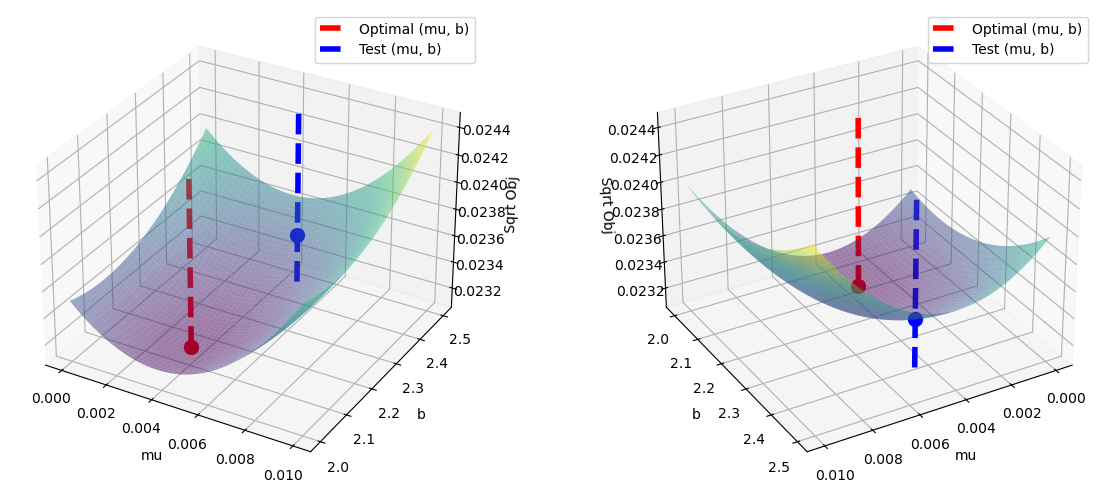

In [613]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Define the range for mu and b
mu_range = np.linspace(0, 0.01, 100)
b_range = np.linspace(2, 2.5, 100)

# Create a meshgrid for mu and b
mu_grid, b_grid = np.meshgrid(mu_range, b_range)

# Calculate the GMM objective function for each pair of (mu, b)
z_values = np.array([gmm_objective((mu, b), X, W)**.5 for mu, b in zip(np.ravel(mu_grid), np.ravel(b_grid))])
z_grid = z_values.reshape(mu_grid.shape)

# Add another view to the same graph
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(mu_grid, b_grid, z_grid, cmap='viridis', alpha=0.5)
ax1.plot([result.x[0]], [result.x[1]], [z_grid.min(), z_grid.max()], color='r', linestyle='--', linewidth=4, label='Optimal (mu, b)')
ax1.scatter(result.x[0], result.x[1], result.fun**.5, color='r', s=100)
ax1.plot([theta_test[0]], [theta_test[1]], [z_grid.min(), z_grid.max()], color='b', linestyle='--', linewidth=4, label='Test (mu, b)')
ax1.scatter(theta_test[0], theta_test[1], gmm_objective(theta_test, X, W)**.5, color='b', s=100)
ax1.set_xlabel('mu')
ax1.set_ylabel('b')
ax1.set_zlabel('Sqrt Obj')
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(mu_grid, b_grid, z_grid, cmap='viridis', alpha=0.5)
ax2.plot([result.x[0]], [result.x[1]], [z_grid.min(), z_grid.max()], color='r', linestyle='--', linewidth=4, label='Optimal (mu, b)')
ax2.scatter(result.x[0], result.x[1], result.fun**.5, color='r', s=100)
ax2.plot([theta_test[0]], [theta_test[1]], [z_grid.min(), z_grid.max()], color='b', linestyle='--', linewidth=4, label='Test (mu, b)')
ax2.scatter(theta_test[0], theta_test[1], gmm_objective(theta_test, X, W)**.5, color='b', s=100)
ax2.view_init(elev=30, azim=60)  # Change the view angle
ax2.set_xlabel('mu')
ax2.set_ylabel('b')
ax2.set_zlabel('Sqrt Obj')
ax2.legend()

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.3)

plt.show()

In [614]:
result.x

array([0.00382517, 2.12042336])

In [615]:
theta_hat_iid

array([0.00495821, 2.43045266])

In [616]:
gradient_matrix(theta_hat_iid,X).T@W@moments(theta_hat_iid,X).mean(axis=0)

array([-1.51115507e-05,  3.06044252e-05])

In [617]:
gradient_matrix(theta_hat_iid,X,alt_approach=True).T@W@moments(theta_hat_iid,X).mean(axis=0)


array([-1.72190415e-05, -1.00246148e-03])

In [618]:
gradient_matrix(theta_hat_iid,X,alt_approach=True) - gradient_matrix(theta_hat_iid,X)

array([[-1.72929586e-06, -8.47679425e-04],
       [ 1.00438450e-05,  4.92336849e-03],
       [-7.26075150e-06, -3.55913051e-03],
       [ 1.27849514e-05,  6.26702494e-03],
       [-6.53719817e-06, -3.20445363e-03],
       [ 1.89437763e-05,  9.28600467e-03],
       [-1.89376474e-05, -9.28300037e-03],
       [ 2.46024136e-05,  1.20597986e-02],
       [-1.52536438e-05, -7.47714740e-03],
       [ 1.78199697e-06,  8.73512856e-04],
       [-2.20869165e-05, -1.08267331e-02],
       [ 2.13124600e-05,  1.04471041e-02],
       [-1.48414840e-05, -7.27511174e-03],
       [ 8.31757819e-06,  4.07717388e-03],
       [-1.33626528e-05, -6.55020700e-03],
       [ 1.66155325e-05,  8.14472840e-03],
       [-9.42357208e-06, -4.61931840e-03],
       [ 7.88063386e-06,  3.86298918e-03],
       [-3.60959330e-05, -1.76937796e-02],
       [ 3.94563672e-05,  1.93410229e-02],
       [-2.39843957e-05, -1.17568539e-02],
       [ 2.75536787e-05,  1.35064722e-02],
       [-4.36344043e-05, -2.13890449e-02],
       [ 8.